In [1]:
from deepface.basemodels import ArcFace
from keras.models import Model
import matplotlib.pyplot as plt
import dlib
from deepface.modules.preprocessing import resize_image
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from deepface.modules.detection import extract_faces
import glob
import re

import os
from keras.losses import CosineSimilarity, cosine_similarity
from deepface import DeepFace
import pandas as pd
from typing import TypedDict
from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import cdist
import random
import tensorflow as tf
from typing import Dict

from keras.losses import MeanSquaredError

arcface_model = ArcFace.load_model()

random.seed(13)

2024-06-16 01:40:58.621799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 01:40:58.694916: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 01:40:59.050200: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12/lib64:/usr/local/cuda-12/lib64
2024-06-16 01:40:59.050233: W tensorflow/compile

In [2]:
dataset_images_path = "dataset"


class ImageCache:
    def __init__(self) -> None:
        self.cache: Dict[str, np.ndarray] = {}

    def get(self, image_path: str):
        if image_path not in self.cache:
            self.cache[image_path] = self._load_image_and_resize(image_path)
        return self.cache[image_path]

    def _load_image_and_resize(self, path) -> np.ndarray:
        img = dlib.load_rgb_image(path)  # type: ignore
        img = resize_image(
            img, target_size=arcface_model.input_shape[1:3]
        )  # ignoring batch and channels shapes
        return img


image_cache = ImageCache()

# Create database as parquet file if not exists


In [3]:
profile_names = [os.path.basename(path) for path in glob.glob("dataset/*")]

In [4]:
max_photos_per_profile = 100


# the database is a dataframe with the columns profile_path (path to photo) and embedding (512dim vector)
def create_database(dataset_images_path: str, output_path: str, model: Model) -> None:
    assert output_path.endswith(
        ".parquet"
    ), f"The database should be saved as a parquet file, but got {output_path}"
    embeddings_df = pd.DataFrame(columns=["profile_path", "embedding"])

    data = []
    paths = []
    for name in tqdm(profile_names):
        loaded_profiles = 0
        profile_paths = glob.glob(dataset_images_path + f"/{name}/profile/*.jpeg")
        for db_img in profile_paths:
            loaded_db_image = image_cache.get(db_img)
            loaded_profiles += 1
            data.append(loaded_db_image)
            paths.append(db_img)
            if loaded_profiles >= max_photos_per_profile:
                break

    data = np.stack(data).squeeze()

    embeddings = model.predict([data])

    embeddings_df["profile_path"] = paths
    embeddings_df["embedding"] = embeddings.tolist()

    embeddings_df.to_parquet(output_path)


create_database(dataset_images_path, "database.parquet", arcface_model)

db = pd.read_parquet("database.parquet")

100%|██████████| 132/132 [00:02<00:00, 52.33it/s]
2024-06-16 01:41:04.246714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907


  8/163 [>.............................] - ETA: 3s

2024-06-16 01:41:05.125087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


163/163 [==============================] - 6s 28ms/step


# Test vanilla version of model


In [5]:
def get_cosine_distance(a: np.ndarray, b: np.ndarray) -> np.float64:
    tensor_value = -tf.reduce_sum(tf.linalg.l2_normalize(a) * tf.linalg.l2_normalize(b))
    return tensor_value.numpy()


pairs_arrays = np.random.uniform(-1, 1, (100, 2, 512))

for i in range(100):
    a = pairs_arrays[i][0]
    b = pairs_arrays[i][1]
    left = get_cosine_distance(a, b)
    right = CosineSimilarity()(tf.constant(a), tf.constant(b)).numpy()
    assert np.isclose(left, right), f"Expected {left} to be close to {right}"

In [6]:
class NearestProfile(TypedDict):
    profile_path: str
    distance: float


class BulkNearestProfiles(TypedDict):
    img_path: "list[str]"
    distance: "list[float]"


def bulk_find_nearest(
    img_paths: "list[str]", arcface_model: Model, database
) -> BulkNearestProfiles:
    if isinstance(img_paths[0], str):
        img_arrays = []
        for path in img_paths:
            img_arrays.append(image_cache.get(path))
    elif isinstance(img_paths[0], np.ndarray):
        img_arrays = img_paths

    img_embeddings = arcface_model.predict(np.concatenate(img_arrays), verbose=0)

    distances = cdist(
        img_embeddings,
        np.stack(database["embedding"]),
        metric="cosine",
    )

    return {
        "img_path": database.loc[distances.argmin(axis=1), "profile_path"].to_list(),
        "distance": distances.min(axis=1).tolist(),
    }


data = random.sample(glob.glob("dataset/*/test_positive/*.jpeg"), 500)
print(data)
res = bulk_find_nearest(data, arcface_model, db)
print(res["img_path"])

['dataset/Rachel_Griffiths/test_positive/Rachel_Griffiths_68754_31345.jpeg', 'dataset/Russell_Crowe/test_positive/Russell_Crowe_99204_51207.jpeg', 'dataset/Alfred_Molina/test_positive/Alfred_Molina_4052_2444.jpeg', 'dataset/Jimmy_Fallon/test_positive/Jimmy_Fallon_58693_31417.jpeg', 'dataset/Alan_Arkin/test_positive/Alan_Arkin_2765_1601.jpeg', 'dataset/Crystal_Chappell/test_positive/Crystal_Chappell_30086_13953.jpeg', 'dataset/Edi_Gathegi/test_positive/Edi_Gathegi_35185_18561.jpeg', 'dataset/Alfred_Molina/test_positive/Alfred_Molina_3943_2365.jpeg', 'dataset/Aisha_Hinds/test_positive/Aisha_Hinds_78817_35710.jpeg', 'dataset/Brianna_Brown/test_positive/Brianna_Brown_22990_10513.jpeg', 'dataset/Shannon_Kane/test_positive/Shannon_Kane_87495_39732.jpeg', 'dataset/Chyler_Leigh/test_positive/Chyler_Leigh_95846_43278.jpeg', 'dataset/Edie_Falco/test_positive/Edie_Falco_53177_25026.jpeg', 'dataset/Paul_Walker/test_positive/Paul_Walker_91019_47463.jpeg', 'dataset/Lauren_Holly/test_positive/Lauren_

# Create dataset for finetuning (Snapchat)


In [7]:
snapchat_filter_images = glob.glob("snapchat/*/test_positive/*.jpeg")
for img in snapchat_filter_images:
    has_matching_in_dataset = os.path.exists(img.replace("snapchat", "dataset"))
    assert has_matching_in_dataset

# tuples of (original image, snapchat image) ndarrays, shape (1, arcface height, arcface width, 3 channels), ground truth = same person
finetuning_dataset = []

for img in tqdm(snapchat_filter_images):
    snapchat_array = image_cache.get(img)
    orig_array = image_cache.get(img.replace("snapchat", "dataset"))
    finetuning_dataset.append((orig_array, snapchat_array))

  0%|          | 0/5143 [00:00<?, ?it/s]

100%|██████████| 5143/5143 [00:04<00:00, 1036.38it/s]


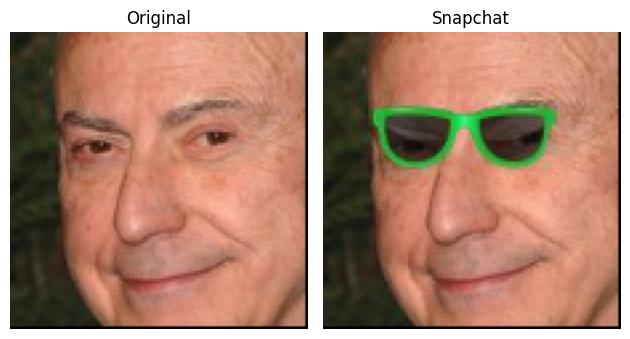

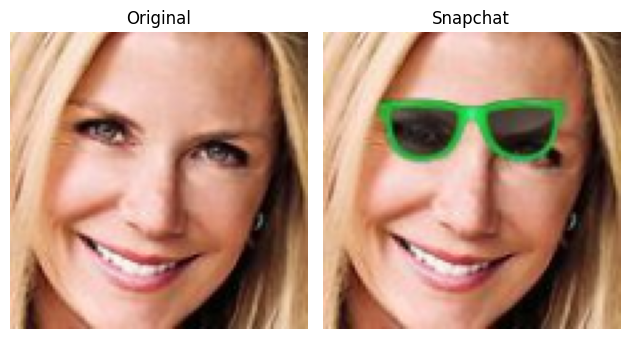

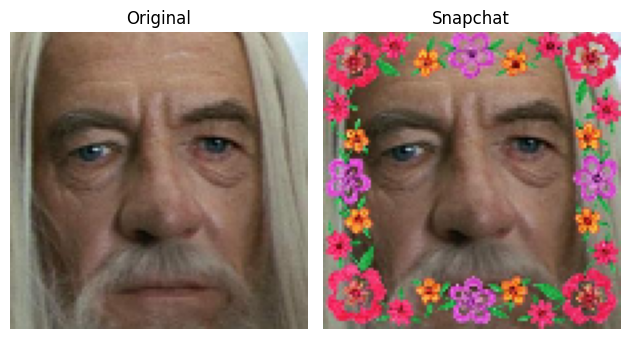

In [8]:
for orig, snap in random.sample(finetuning_dataset, 3):
    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(orig.squeeze())
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(snap.squeeze())
    axs[1].set_title("Snapchat")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

# Create validation dataset (to prevent overfit)


In [9]:
validation_dataset = []
# tuples of (profile image, test positive image) ndarrays, shape (1, arcface height, arcface width, 3 channels), ground truth = same person


for profile in tqdm(profile_names):
    profile_images = glob.glob(f"dataset/{profile}/profile/*.jpeg")
    test_positive_images = glob.glob(f"dataset/{profile}/test_positive/*.jpeg")
    max_pairs_per_profile = 10
    profile_pairs_count = 0
    for profile_img in profile_images:
        for test_positive_img in test_positive_images:
            profile_array = image_cache.get(profile_img)
            test_positive_array = image_cache.get(test_positive_img)
            validation_dataset.append((profile_array, test_positive_array))
            profile_pairs_count += 1
            if profile_pairs_count >= max_pairs_per_profile:
                break

100%|██████████| 132/132 [00:00<00:00, 3835.08it/s]


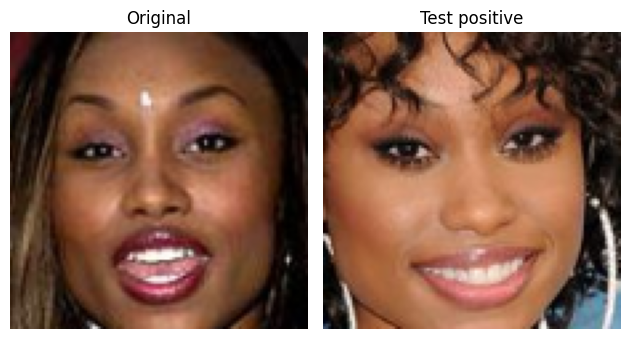

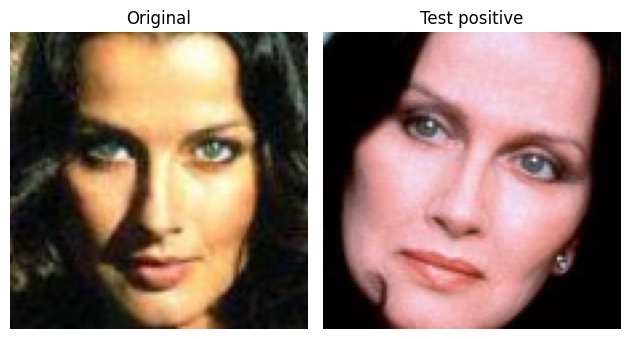

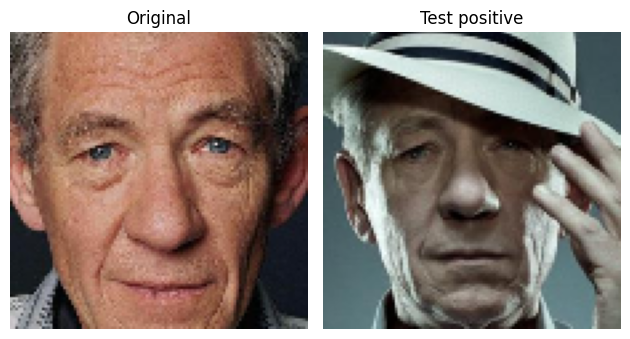

In [10]:
for profile, test_positive in random.sample(validation_dataset, 3):
    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(profile.squeeze())
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(test_positive.squeeze())
    axs[1].set_title("Test positive")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

In [11]:
path_finder = re.compile(r"(.*)(dataset|snapchat)/(.*)/(.*)/(.*\.jpeg)")

# Measure model stats before finetuning


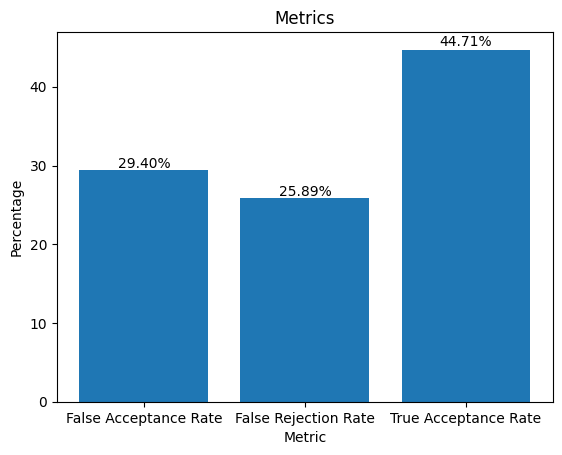

In [12]:
threshold = 0.4


def test_acceptances(model, database):
    true_acceptances = 0
    false_acceptances = 0
    false_rejections = 0

    snapchat_subset = glob.glob("snapchat/*/test_positive/*.jpeg")
    database_subset = glob.glob("dataset/*/test_positive/*.jpeg")
    positive_subset = snapchat_subset + database_subset

    preds = bulk_find_nearest(positive_subset, model, database)

    for sample_path, predicted_path, distance in zip(
        positive_subset, preds["img_path"], preds["distance"]
    ):
        expected = path_finder.match(sample_path).group(2)
        result = path_finder.match(predicted_path).group(2)
        if distance > threshold:
            false_rejections += 1
        elif result == expected:
            true_acceptances += 1
        else:
            false_acceptances += 1

    true_acceptance_rate = true_acceptances / len(positive_subset)
    false_acceptance_rate = false_acceptances / len(positive_subset)
    false_rejection_rate = false_rejections / len(positive_subset)

    # Define the metrics and their values
    metrics = ["False Acceptance Rate", "False Rejection Rate", "True Acceptance Rate"]
    values = [
        false_acceptance_rate * 100,
        false_rejection_rate * 100,
        true_acceptance_rate * 100,
    ]

    # Create the bar plot
    plt.bar(metrics, values)

    # Add labels above each bar
    for i, value in enumerate(values):
        plt.text(i, value * 1.01, f"{value:.2f}%", ha="center")

    # Set the title and labels
    plt.title("Metrics")
    plt.xlabel("Metric")
    plt.ylabel("Percentage")

    # Display the plot
    plt.show()


test_acceptances(model=arcface_model, database=db)

# Prepare model for finetuning


In [13]:
# freeze all but last 10% of layers in arcface_model
for layer in arcface_model.layers[: -int(len(arcface_model.layers) * 0.1)]:
    layer.trainable = False

In [14]:
from keras.layers import Input, Lambda
from keras.models import Model

input_1 = Input(shape=arcface_model.input_shape[1:])
input_2 = Input(shape=arcface_model.input_shape[1:])

output_1 = arcface_model(input_1)
output_2 = arcface_model(input_2)


def get_cosine_similarity(vectors):
    x, y = vectors
    return cosine_similarity(
        x, y
    )  # this returns value from -1 (same vectors) to 1 (opposite vectors)


cosine_sim = Lambda(get_cosine_similarity)([output_1, output_2])

arcface_wrapped = Model(inputs=[input_1, input_2], outputs=cosine_sim)


# sanity check
val_sample = random.sample(validation_dataset, 10)
a = np.concatenate([v[0] for v in val_sample], axis=0)
b = np.concatenate([v[1] for v in val_sample], axis=0)

left = arcface_wrapped.predict([a, b], verbose=0)
right = cosine_similarity(
    tf.constant(arcface_model.predict(a, verbose=0)),
    tf.constant(arcface_model.predict(b, verbose=0)),
).numpy()

for l, r in zip(left, right):
    assert np.isclose(l, r, rtol=1e-3), f"Expected {l} to be close to {r}"

In [15]:
# very gentle optimization
optimizer = Adam(learning_rate=1e-6)
num_epochs = 5
batch_size = 32

In [16]:
arcface_wrapped.compile(
    optimizer=optimizer,
    loss=MeanSquaredError(),
    metrics=["mse"],
)

In [17]:
finetune_left_pair = np.concatenate([x[0] for x in finetuning_dataset], axis=0)
finetune_right_pair = np.concatenate([x[1] for x in finetuning_dataset], axis=0)

validation_left_pair = np.concatenate([x[0] for x in validation_dataset], axis=0)
validation_right_pair = np.concatenate([x[1] for x in validation_dataset], axis=0)

model_path = "arcface_finetuned.h5"

history = arcface_wrapped.fit(
    x=[finetune_left_pair, finetune_right_pair],
    y=-np.ones((len(finetune_left_pair),)),
    batch_size=batch_size,
    epochs=num_epochs,
    shuffle=True,
    callbacks=[
        ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True)
    ],
    validation_data=(
        [validation_left_pair, validation_right_pair],
        -np.ones((len(validation_left_pair),)),
    ),
)

Epoch 1/5
161/161 [==============================] - ETA: 0s - loss: 0.0904 - mse: 0.0904
Epoch 1: val_loss improved from inf to 0.25830, saving model to arcface_finetuned.h5
161/161 [==============================] - 28s 161ms/step - loss: 0.0904 - mse: 0.0904 - val_loss: 0.2583 - val_mse: 0.2583
Epoch 2/5
161/161 [==============================] - ETA: 0s - loss: 0.0877 - mse: 0.0876
Epoch 2: val_loss improved from 0.25830 to 0.25503, saving model to arcface_finetuned.h5
161/161 [==============================] - 24s 148ms/step - loss: 0.0877 - mse: 0.0876 - val_loss: 0.2550 - val_mse: 0.2551
Epoch 3/5
161/161 [==============================] - ETA: 0s - loss: 0.0862 - mse: 0.0862
Epoch 3: val_loss did not improve from 0.25503
161/161 [==============================] - 23s 146ms/step - loss: 0.0862 - mse: 0.0862 - val_loss: 0.2574 - val_mse: 0.2574
Epoch 4/5
161/161 [==============================] - ETA: 0s - loss: 0.0845 - mse: 0.0845
Epoch 4: val_loss did not improve from 0.25503


<Axes: >

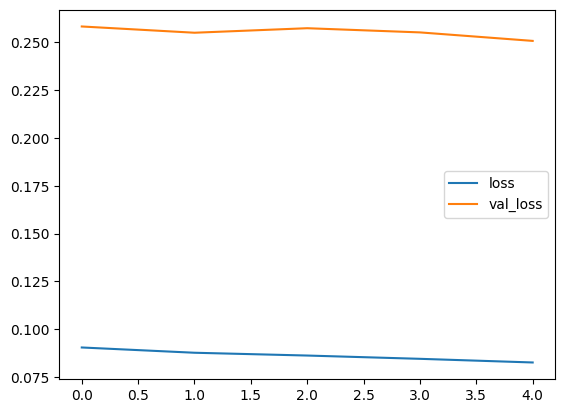

In [18]:
history_df = pd.DataFrame(history.history)
history_df[["loss", "val_loss"]].plot()

100%|██████████| 132/132 [00:00<00:00, 19656.61it/s]


163/163 [==============================] - 4s 27ms/step


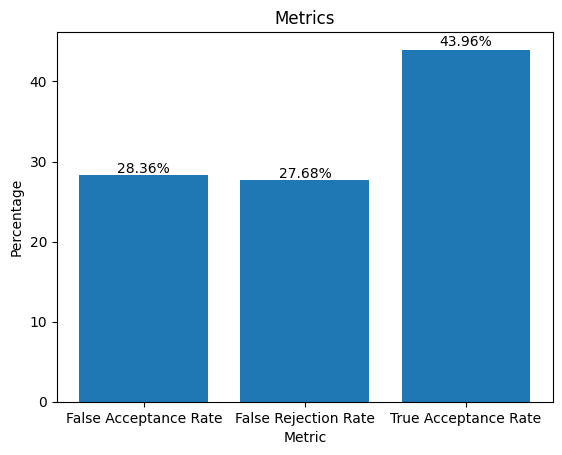

In [19]:
arcface_wrapped.load_weights(model_path)
finetuned_arcface = arcface_wrapped.layers[
    -2
]  # the underlying backbone arcface model that returns embeddings

create_database(
    dataset_images_path, "database_after_finetuning.parquet", finetuned_arcface
)

database_after_finetuning = pd.read_parquet("database_after_finetuning.parquet")

test_acceptances(model=finetuned_arcface, database=database_after_finetuning)